In [50]:
%load_ext watermark
%watermark -a "James Kunert-Graf" -d -v -m -p h5py,copy,glob,numpy,matplotlib,scipy,networkx -g -u

James Kunert-Graf 
last updated: 2018-05-01 

CPython 2.7.12
IPython 5.6.0

h5py 2.7.0
copy n
glob n
numpy 1.14.2
matplotlib 2.0.2
scipy 1.0.0
networkx 1.11

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.0-121-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
Git hash   : c52e822031f5725d9d8fe706b4724596f5f08b36


In [1]:
import h5py
import copy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd
import scipy.stats as stats
import networkx as nx

from DMD import DMD
from hcp_dmd_utils import flat2mat,mat2flat

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load reference Resting State Networks and list of subjects for whom clusters were calculated

In [52]:
with h5py.File('./RSN.h5','r') as hf:
    RSNs=np.array(hf['RSNs'])
    RSNlabels=np.array(hf['RSNlabels'])

rsn=[]        
for k in range(RSNs.shape[2]):
    r=RSNs[:,:,k]
    rsn.append(mat2flat(r))
rsn=np.vstack(rsn)
rsnNo=np.arange(RSNs.shape[2])
rsnNo=np.delete(rsnNo,[0,7])
rsn=rsn[rsnNo,:]
rlabs=RSNlabels[rsnNo]

u120=np.genfromtxt('./u120.txt').astype(int).astype(str)
ulist=u120

nmodes=8
nframes=32

finefiles=[]
for runlabel in ['REST1','REST2']:
    for scandir in ['LR','RL']:
    finefiles.append(glob('./DMD_Clusters/*_{:}m_{:}f_*.h5'.format(nmodes,nframes)))

['./DMD_Clusters/REST2_LR_8m_32f_8clusters2.h5',
 './DMD_Clusters/REST1_RL_8m_32f_7clusters2.h5',
 './DMD_Clusters/REST1_LR_8m_32f_9clusters2.h5',
 './DMD_Clusters/REST2_RL_8m_32f_10clusters2.h5']

In [3]:

MODES=[]
MODU=[]

CMS=[]
W=[]
WINU=[]
WINJ=[]
CSUBS=[]
for cfl in finefiles:
    print cfl
    runlabel,scandir,nmodes,nframes=cfl.split('/')[-1].split('.')[0].split('_')[:-1]
    nframes=int(nframes[:-1])
    nmodes=int(nmodes[:-1])

    freq=[]
    power=[]
    F=[]
    ux=[]
    jx=[]
    jno=[]
    rx=[]
    for uid,u in enumerate(ulist):
        fdir='./DMD_results/nmodes{:}_nframes{:}_{:}_{:}/'.format(nmodes,nframes,runlabel,scandir)
        try:
            with h5py.File(fdir+'Modes_{:}.h5'.format(u),'r') as hf:
                F.append(np.array(hf['F']))
            with h5py.File(fdir+'{:}.h5'.format(u),'r') as hf:            
                freq.append(np.array(hf['freq']))
                power.append(np.array(hf['power']))
                ux.append(np.array(hf['ux']))
                jx.append(np.array(hf['jx']))
                jno.append(np.array(hf['jno']))
        except:
            pass
    freq=np.hstack(freq)
    power=np.hstack(power)
    F=np.vstack(F)
    ux=np.hstack(ux).astype(int)
    jx=np.hstack(jx).astype(int)
    jno=np.hstack(jno).astype(int)
    winVals,winNo=np.unique(np.array(['{:03.0f}_{:03.0f}'.format(ux[k],jx[k]) for k in range(len(jx))]),return_inverse=True)
    winu,winj=np.vstack([np.array(wv.split('_')).astype(int) for wv in winVals]).T
    uidx=np.unique(ux,return_inverse=True)[1]

    with h5py.File(cfl,'r') as hf:
        clusters=np.array(hf['clusters'])
        
    modes=[]
    modu=np.zeros((len(clusters),120))
    for k,c in enumerate(clusters):
        modu[k,np.unique(ux[c]).astype(int)]=1
        modes.append(np.mean(F[c],0))
    modes=np.vstack(modes)
    
    MODES.append(modes)
    MODU.append(modu)
    
    #calculate where modes exist in same window and what coupling coefficients are
    windows=[]
    for k,c in enumerate(clusters):
        windows.append(np.unique(winNo[c]))
    CM=np.zeros([len(windows)]*2)
    for i in range(len(windows)):
        for j in range(len(windows)):
            shared_wins=np.intersect1d(windows[i],windows[j])
            CM[i,j]=len(shared_wins)
            CM[j,i]=len(shared_wins)                    
    CMS.append(CM)
    W.append(np.array(windows))
    WINU.append(winu)
    WINJ.append(winj)

nbit=np.argmin([len(mj) for mj in MODES])
M=copy.copy(MODES)
MU=copy.copy(MODU)
m1=M.pop(nbit)
mu1=MU.pop(nbit)

ff=copy.copy(finefiles)
ff1=ff.pop(nbit)
ff=[ff1]+ff
fflab=['_'.join(f.split('/')[-1].split('_')[:2]) for f in ff]

CMlist=copy.copy(CMS)
cm1=CMlist.pop(nbit)



C=[]
for k,m2 in enumerate(M):
    c=1-ssd.cdist(m1,m2,metric='correlation')
    C.append(c.max(1))
C=np.vstack(C)
reposort=np.flipud(np.argsort(C.prod(0)))

m1=m1[reposort]

C=[]
CIX=[]
Msort=[]
MUsort=[]
CMsort=[]
for k,m2 in enumerate(M):
    c=1-ssd.cdist(m1,m2,metric='correlation')
    C.append(c.max(1))
    #just taking the argmax:
    cix=[]
    invalid=np.zeros(c.shape[1]).astype(bool)
    for r,cr in enumerate(c):
        cr[invalid]=0
        cir=np.argmax(cr)
        invalid[cir]=True
        cix.append(cir)
    cix=np.array(cix)

    CIX.append(cix)
    Msort.append(m2[cix])
    MUsort.append(MU[k][cix,:])
    
    CMsort.append(CMlist[k][cix,:][:,cix])

C=np.vstack(C)

Msort=[m1]+Msort
Msort=np.dstack(Msort)
MUsort=[mu1]+MUsort
MUsort=np.dstack(MUsort)
CMsort=[cm1]+CMsort
CMsort=np.dstack(CMsort)
cp=np.flipud(np.sort(C.prod(0)))

#%
nord=-1
trialsort=[]
for k in range(4):
    if k==nbit:
        trialsort.append(reposort)
    else:
        nord+=1
        trialsort.append(CIX[nord])

#%

N=6

./DMD_Clusters/REST2_LR_8m_32f_8clusters2.h5
./DMD_Clusters/REST1_RL_8m_32f_7clusters2.h5
./DMD_Clusters/REST1_LR_8m_32f_9clusters2.h5
./DMD_Clusters/REST2_RL_8m_32f_10clusters2.h5


./DMD_Clusters/REST2_LR_8m_32f_8clusters2.h5
./DMD_Clusters/REST1_RL_8m_32f_7clusters2.h5
./DMD_Clusters/REST1_LR_8m_32f_9clusters2.h5
./DMD_Clusters/REST2_RL_8m_32f_10clusters2.h5


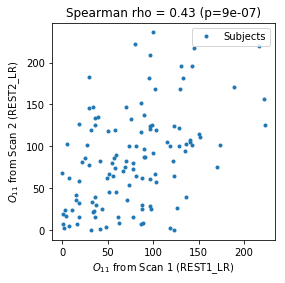

In [4]:
CSUBS=[]
for kcfl,cfl in enumerate(finefiles):
    print cfl
    runlabel,scandir,nmodes,nframes=cfl.split('/')[-1].split('.')[0].split('_')[:-1]
    nframes=int(nframes[:-1])
    nmodes=int(nmodes[:-1])

    ux=[]
    jx=[]
    for uid,u in enumerate(ulist):
        fdir='./DMD_results/nmodes{:}_nframes{:}_{:}_{:}/'.format(nmodes,nframes,runlabel,scandir)
        try:
            with h5py.File(fdir+'{:}.h5'.format(u),'r') as hf:            
                ux.append(np.array(hf['ux']))
                jx.append(np.array(hf['jx']))
        except:
            pass
    ux=np.hstack(ux).astype(int)
    jx=np.hstack(jx).astype(int)
    with h5py.File(cfl,'r') as hf:
        clusters=np.array(hf['clusters'])

    
    Nsub=len(np.unique(ux))
    Csub=np.zeros((120,N))
    for k,ck in enumerate(trialsort[kcfl][:N]):
      #find subject number, window number of modes within each cluster
      uclust=ux[clusters[ck]]
      jclust=jx[clusters[ck]]
      #iterate through subjects to get unique window numbers
      for uk in np.unique(uclust):
        Csub[uk,k]=len(np.unique(jclust[uclust==uk]))
    CSUBS.append(Csub)
CSUBS=np.stack(CSUBS)

socc=CSUBS[:,:,0]
j=-1;k=-1
for kcfl,cfl in enumerate(finefiles):
    runlabel,scandir,_,_=cfl.split('/')[-1].split('.')[0].split('_')[:-1]
    if scandir=='LR':
        if runlabel=='REST1':
            j=kcfl
        if runlabel=='REST2':
            k=kcfl

c,p=stats.spearmanr(socc[j],socc[k])
plt.figure(figsize=(4,4))
plt.plot(socc[j],socc[k],'.',label='Subjects')
plt.xlabel('$O_{11}$ from Scan 1 (REST1_LR)')
plt.ylabel('$O_{11}$ from Scan 2 (REST2_LR)')
plt.title('Spearman rho = {:0.2f} (p={:0.0e})'.format(c,p))
plt.legend()
plt.savefig('./Figures/correlation_example.svg')

In [5]:
c=[]
p=[]
for k in range(6):  
    #'sock' = subject-level occupancy for mode k
    sock=CSUBS[:,:,k]
    ck,pk=stats.spearmanr(sock.T)

    #keep median correlations, p-values
    ck=np.median(ck[np.triu_indices(ck.shape[0],1)])
    pk=np.median(pk[np.triu_indices(pk.shape[0],1)])
    c.append(ck)
    p.append(pk)

    
#print correlations, p-values in format compatible with LaTeX
for k,ck in enumerate(c):
    print 'Mode {:} & {:0.2f} & {:0.1e} \\\\'.format(k+1,ck,p[k])

Mode 1 & 0.43 & 1.3e-06 \\
Mode 2 & 0.43 & 1.4e-05 \\
Mode 3 & 0.25 & 5.7e-03 \\
Mode 4 & 0.31 & 9.9e-04 \\
Mode 5 & 0.19 & 1.0e-01 \\
Mode 6 & 0.07 & 4.5e-01 \\


In [7]:
TS=[]
for run in range(4):
    Ts=[]
    for uid in range(len(ulist)):
        #loop through different cluster numbers, return matrix showing occurence of each cluster in individual's windows
        WIX=[]
        T=np.zeros((N,jx.max()+1))
        for n in range(N):
            #get window numbers corresponding to run & cluster number
            wix=W[run][trialsort[run]][n]
            #narrow down to single individual 'uid'
            wix=wix[WINU[run][wix]==uid]
            #convert from absolute indices to inter-run indices
            wix=WINJ[run][wix]
            T[n,wix]=1
        Ts.append(T)
    TS.append(np.stack(Ts))
TS=np.stack(TS)

def occMat(run,N=6):
    return CMS[run][:,trialsort[run]][trialsort[run],:][:N,:N]

def transMat(run,dt,N=6):
    Ms=[]
    for uid in range(len(ulist)):
        tu=TS[run,uid][:,:(293-dt)]
        M=[]
        for k in range(N):
            #indices where mode is on
            non=np.where(tu[k])[0]
            if len(non)>0:
                M.append(np.sum(TS[run,uid][:,non+dt],1))
            else:
                M.append(np.zeros((1,N)))
        Ms.append(np.vstack(M))
    return np.sum(np.stack(Ms),0)/np.diag(occMat(run,N=N))[:,None]

([], <a list of 0 Text yticklabel objects>)

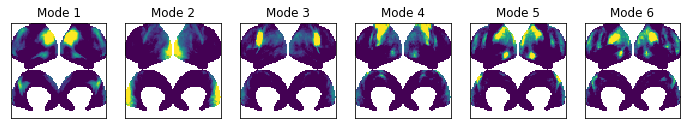

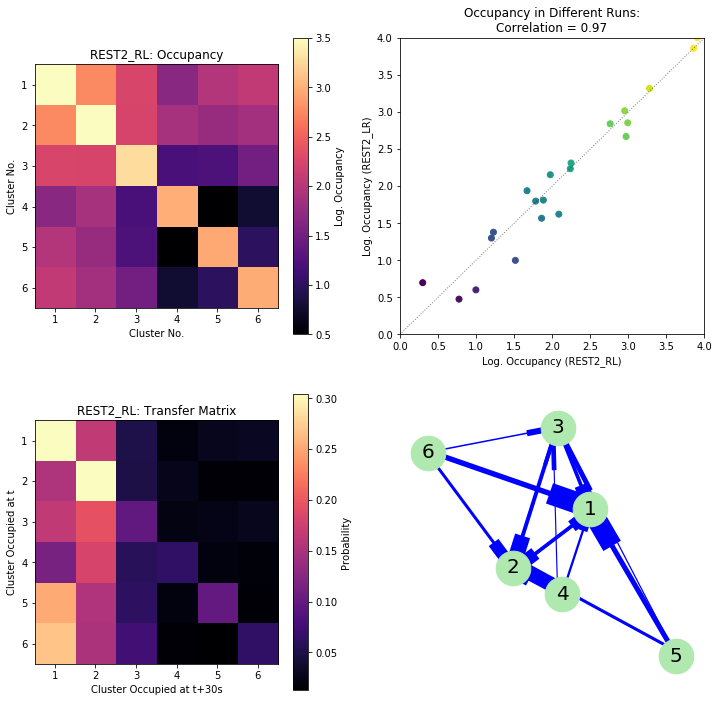

In [49]:
frame_shift=4
tstep=(14*60+33.)/1200*frame_shift

Msort.shape
plt.figure(figsize=(12,3))
for k,modek in enumerate(Msort[:6]):
    modek=modek.mean(-1)
    modek=(modek-modek.mean())/modek.std()
    modek=flat2mat(modek)
    modek[modek==0]=np.nan
    plt.subplot(1,6,k+1)
    plt.imshow(modek,vmin=0,vmax=2.5)
    plt.xticks([]);plt.yticks([])
    plt.title('Mode {:}'.format(k+1))


plt.figure(figsize=(12,12))
N=6
ffl=['_'.join(f.split('/')[-1].split('_')[:2]) for f in finefiles]

plt.subplot(2,2,1)
n=3
plt.title('{:}: Occupancy'.format(ffl[n]))
occ=occMat(n)
plt.imshow(np.log10(occ),vmin=0.5,vmax=3.5,cmap='magma')
plt.colorbar(label='Log. Occupancy')
plt.xticks(np.arange(N),np.arange(1,N+1))
plt.yticks(np.arange(N),np.arange(1,N+1))
plt.xlabel('Cluster No.');plt.ylabel('Cluster No.')

plt.subplot(2,2,2)
i=3;j=0;
occ1=np.log10(occMat(i)[np.triu_indices(N)])
occ2=np.log10(occMat(j)[np.triu_indices(N)])
plt.plot([0,4],[0,4],':',c=[0,0,0,0.5],lw=1)
plt.scatter(occ1,occ2,c=(occ1+occ2)/2.0,cmap='viridis',vmin=0.5,vmax=3.5)
plt.xlabel('Log. Occupancy ({:})'.format(ffl[i]));
plt.ylabel('Log. Occupancy ({:})'.format(ffl[j]));
plt.xlim([0,4]);plt.ylim([0,4])
plt.title('Occupancy in Different Runs:\nCorrelation = {:0.2f}'.format(np.corrcoef(occ1,occ2)[0][1]))

Tmat=transMat(n,40)
plt.subplot(2,2,3)
dt=int(30./tstep)
plt.imshow(Tmat,cmap='magma')
plt.ylabel('Cluster Occupied at t')
plt.xlabel('Cluster Occupied at t+30s')
plt.title('{:}: Transfer Matrix'.format(ffl[n]))
plt.colorbar(label='Probability')
plt.xticks(np.arange(N),np.arange(1,N+1))
plt.yticks(np.arange(N),np.arange(1,N+1))


G=nx.DiGraph()
edgelist=[]
edgeweight=[]
for i in range(N):
    for j in range(N):
        if i!=j:
            edgelist.append((i+1,j+1))
            edgeweight.append(Tmat[i,j])
G.add_edges_from(edgelist)
elist=[(u,v) for (u,v,d) in G.edges(data=True)]
pos=nx.spring_layout(G)
ag=plt.subplot(2,2,4,frameon=False)
nx.draw_networkx_nodes(G,pos,with_labels=True,ax=ag,node_size=1200,node_color=[175./255,233./255,175./255])
for k,e in enumerate(edgelist):
    eweight=edgeweight[k]
    if eweight>0.04:
        #print '({:},{:}):{:}'.format(e[0],e[1],eweight)
        pose=copy.deepcopy(pos)
        shift=np.random.randn(2)*0.01
        pose[e[0]]+=shift
        pose[e[1]]+=shift
        nx.draw_networkx_edges(G,pose,edgelist=[(e[0],e[1])],width=20*eweight,alpha=1.0,edge_color='b',arrows=True)
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif',ha='center',va='center')
plt.xticks([]);plt.yticks([])